<a href="https://www.kaggle.com/code/dataranch/lung-cancer-prediction-28-models-fastai?scriptVersionId=107602005" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# <div style="text-align: center; background-color: blue; color: white; padding: 14px; line-height: 1;border-radius:20px">**Lung Cancer Prediction | Model Comparison + Feature Importance 📊**</div>
- Preprocessing
    - Detect continuous and categorical variables.
    - Normalize and impute data.
    

- For every target variable in the dataset:
    - Compare performance on 27 models + a TabNet model.
    - Output model performance and processed data in CSV format for every dataset.
    - Save plots + CSVs of XGBoost Feature Importances.
    - Save best performing FastAI model.

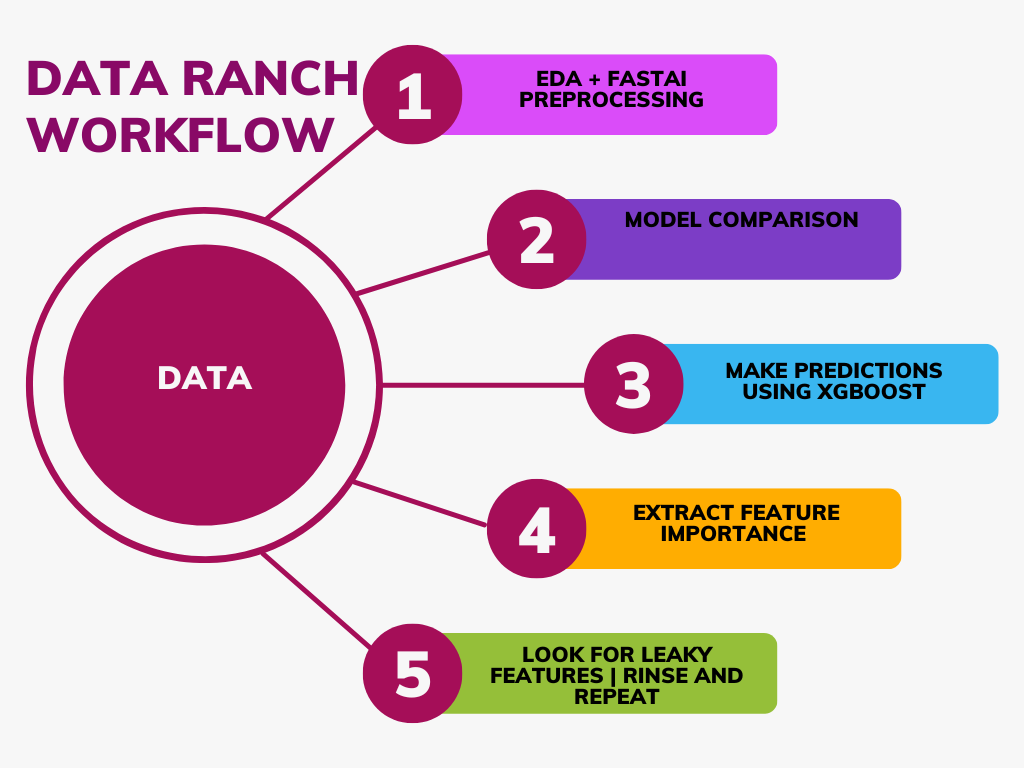

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install lazypredict

In [3]:
!pip install --upgrade pandas

In [4]:
!pip install fast-tabnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 517.0 kB/s eta 0:00:00


In [5]:
!pip install fastai

  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.3.0
    Uninstalling typing_extensions-4.3.0:
      Successfully uninstalled typing_extensions-4.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
tensorflow 2.6.4 requires h5py~=3.1.0, but you have h5py 3.7.0 which is incompatible.
tensorflow 2.6.4 requires numpy~=1.19.2, but you have numpy 1.21.6 which is incompatible.
tensorflow 2.6.4 requires tensorboard<2.7,>=2.6.0, but you have tensorboard 2.10.0 which is incompatible.
tensorflow 2.6.4 requires typing-extensions<3.11,>=3.7, but you have typing-extensions 4.1.1 which is incompatible.
tensorflow-transform 1.9.0 requires pyarrow<6,>=1, but you have pyarrow 8.0.0 which is incompatible.
tensorflow-transform 1.9.0 requires te

In [6]:
!pip install pandas-profiling

  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 2.1.1
    Uninstalling MarkupSafe-2.1.1:
      Successfully uninstalled MarkupSafe-2.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
beatrix-jupyterlab 3.1.7 requires google-cloud-bigquery-storage, which is not installed.
werkzeug 2.2.2 requires MarkupSafe>=2.1.1, but you have markupsafe 2.0.1 which is incompatible.


In [7]:
#A program that takes a csv and trains models on it. Streamlined model selection.
#==============================================================================

#LazyPredict
import lazypredict
from lazypredict.Supervised import LazyRegressor
from lazypredict.Supervised import LazyClassifier
#Baysian Optimization
from bayes_opt import BayesianOptimization
#Pandas stack
import pandas as pd
import pandas_profiling
import numpy as np
#FastAI
from fastai.tabular.all import *
from fastai.tabular.core import *
#Plots
import matplotlib.pyplot as plt
import seaborn as sns
#System
import os
import sys
import traceback
#Fit an xgboost model
from xgboost import XGBRegressor
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
#Random
import random

#TabNet
from fast_tabnet.core import *

import shutil

In [8]:
%matplotlib inline

In [9]:
# For Styling
plt.style.use('seaborn-bright')

In [10]:
#Project Variables
#===================================================================================================
PROJECT_NAME = 'smoking-related-lung-cancers'
VARIABLE_FILES = False
#Maximum amount of rows to take
SAMPLE_COUNT = 100000
FASTAI_LEARNING_RATE = 1e-1
AUTO_ADJUST_LEARNING_RATE = False
#Set to True automatically infer if variables are categorical or continuous
ENABLE_BREAKPOINT = True
#When trying to declare a column a continuous variable, if it fails, convert it to a categorical variable
CONVERT_TO_CAT = False
REGRESSOR = True
SEP_DOLLAR = False
SEP_COMMA = False
SHUFFLE_DATA = True

In [11]:
input_dir = f'../input/{PROJECT_NAME}'
param_dir = f'/kaggle/working/{PROJECT_NAME}'
TARGET = ''
PARAM_DIR = param_dir
print(f'param_dir: {param_dir}')
if not os.path.exists(param_dir):
    os.makedirs(param_dir)
#rename any file in param_dir/file that ends with csv to data.csv
for file in os.listdir(input_dir):
    if file.endswith('.csv'):
        print('CSV!')
        if 'classification_results' not in file and 'regression_results' not in file:
            #os.rename(f'{input_dir}/{file}', f'{param_dir}/data.csv')
            shutil.copy(f'{input_dir}/{file}', f'{param_dir}/data.csv')
        #os.rename(f'{param_dir}/{file}', f'{param_dir}/data.csv')
try:
    df = pd.read_csv(f'{param_dir}/data.csv', nrows=SAMPLE_COUNT)
except:
    print(f'Please place a file named data.csv in {param_dir}')
    #sys.exit()

param_dir: /kaggle/working/smoking-related-lung-cancers
CSV!


In [12]:
df

,pid,age,gender,race,smoker,days_to_cancer,stage_of_cancer
0,100001,70,Male,White,Current,NaN,NaN
1,100002,66,Male,White,Current,NaN,NaN
2,100003,64,Male,White,Current,NaN,NaN
3,100004,60,Male,White,Former,NaN,NaN
4,100005,64,Male,White,Former,NaN,NaN
...,...,...,...,...,...,...,...
53422,218890,73,Female,White,Current,NaN,NaN
53423,218891,66,Male,White,Current,NaN,NaN
53424,218892,56,Male,White,Former,NaN,NaN
53425,218893,69,Male,White,Former,NaN,NaN


In [13]:
df = df.dropna()

In [14]:
df

,pid,age,gender,race,smoker,days_to_cancer,stage_of_cancer
11,100012,61,Female,White,Current,454.00,IA
48,100049,74,Female,White,Current,2428.00,IIB
54,100055,67,Male,White,Former,148.00,IV
146,100147,68,Male,White,Former,491.00,IA
157,100158,65,Male,White,Former,795.00,IA
...,...,...,...,...,...,...,...
53356,218824,60,Female,White,Former,27.00,IB
53366,218834,69,Female,White,Current,71.00,IA
53370,218838,56,Male,White,Current,1077.00,IV
53405,218873,61,Male,White,Former,1632.00,IV


In [15]:
if SEP_DOLLAR:
    #For every column in df, if the column contains a $, make a new column with the value without the $
    for col in df.columns:
        if '$' in df[col].to_string():
            df[col + '_no_dollar'] = df[col].str.replace('$', '').str.replace(',', '')
            #Try to convert this new column to a numeric type
            try:
                df[col + '_no_dollar'] = df[col + '_no_dollar'].apply(pd.to_numeric, errors='coerce').dropna()
            except Exception:
                print(f'{col} can not be converted to a float!')


if SEP_COMMA:
    #For every column in df, if the column contains a %, make a new column with the value without the %
    for col in df.columns:
        if '%' in df[col].to_string() or ',' in df[col].to_string():
            df[col + '_processed'] = df[col].str.replace('%', '').str.replace(',', '')
            #Try to convert this new column to a numeric type
            try:
                df[col + '_processed'] = df[col + '_processed'].apply(pd.to_numeric, errors='coerce').dropna()
            except Exception:
                print(f'{col} can not be converted to a float!')

In [16]:
df

,pid,age,gender,race,smoker,days_to_cancer,stage_of_cancer
11,100012,61,Female,White,Current,454.00,IA
48,100049,74,Female,White,Current,2428.00,IIB
54,100055,67,Male,White,Former,148.00,IV
146,100147,68,Male,White,Former,491.00,IA
157,100158,65,Male,White,Former,795.00,IA
...,...,...,...,...,...,...,...
53356,218824,60,Female,White,Former,27.00,IB
53366,218834,69,Female,White,Current,71.00,IA
53370,218838,56,Male,White,Current,1077.00,IV
53405,218873,61,Male,White,Former,1632.00,IV


In [17]:
df.isna().sum()

pid                0
age                0
gender             0
race               0
smoker             0
days_to_cancer     0
stage_of_cancer    0
dtype: int64

In [18]:
df.profile_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

<AxesSubplot:>

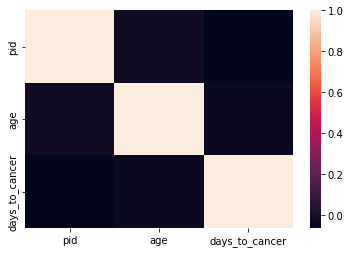

In [19]:
sns.heatmap(df.corr())

In [20]:
df.head().style.background_gradient(cmap = "inferno")

,pid,age,gender,race,smoker,days_to_cancer,stage_of_cancer
11,100012,61,Female,White,Current,454.00,IA
48,100049,74,Female,White,Current,2428.00,IIB
54,100055,67,Male,White,Former,148.00,IV
146,100147,68,Male,White,Former,491.00,IA
157,100158,65,Male,White,Former,795.00,IA


In [21]:
df.describe().T.style.background_gradient(cmap = "viridis")

,count,mean,std,min,25%,50%,75%,max
pid,2022.00,151811.17,45635.87,100012.00,113581.50,127329.00,206546.75,218886.00
age,2022.00,63.68,5.29,55.00,59.00,63.00,68.00,74.00
days_to_cancer,2022.00,1049.88,742.98,0.00,400.25,929.50,1723.00,2618.00


In [22]:
df.columns

Index(['pid', 'age', 'gender', 'race', 'smoker', 'days_to_cancer',
       'stage_of_cancer'],
      dtype='object')

In [23]:
#remove leaky feature
del(df['pid'])

Traceback (most recent call last):
  File "/tmp/ipykernel_19/2031823437.py", line 9, in <module>
    df[df.columns[i]] = df[df.columns[i]].astype(float)
  File "/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py", line 5815, in astype
    new_data = self._mgr.astype(dtype=dtype, copy=copy, errors=errors)
  File "/opt/conda/lib/python3.7/site-packages/pandas/core/internals/managers.py", line 418, in astype
    return self.apply("astype", dtype=dtype, copy=copy, errors=errors)
  File "/opt/conda/lib/python3.7/site-packages/pandas/core/internals/managers.py", line 327, in apply
    applied = getattr(b, f)(**kwargs)
  File "/opt/conda/lib/python3.7/site-packages/pandas/core/internals/blocks.py", line 591, in astype
    new_values = astype_array_safe(values, dtype, copy=copy, errors=errors)
  File "/opt/conda/lib/python3.7/site-packages/pandas/core/dtypes/cast.py", line 1309, in astype_array_safe
    new_values = astype_array(values, dtype, copy=copy)
  File "/opt/conda/lib/pytho

Target Variable: days_to_cancer
CATS=====================
['age', 'gender', 'race', 'smoker', 'stage_of_cancer']
CONTS=====================
[]
5
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : []
Categorical variables that made the cut : ['age', 'gender', 'race', 'smoker', 'stage_of_cancer']
Tabular Object size: 2018


  7%|▋         | 3/42 [00:00<00:01, 28.53it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.052643200378173605, 'Adjusted R-Squared': 0.0407117545391078, 'RMSE': 748.8668932213043, 'Time taken': 0.034715890884399414}
{'Model': 'BaggingRegressor', 'R-Squared': -0.13770528698292206, 'Adjusted R-Squared': -0.15203406893484805, 'RMSE': 820.6589893782902, 'Time taken': 0.038474321365356445}
{'Model': 'BayesianRidge', 'R-Squared': 0.06225668429143394, 'Adjusted R-Squared': 0.05044631507596087, 'RMSE': 745.0575697656259, 'Time taken': 0.03136754035949707}
{'Model': 'DecisionTreeRegressor', 'R-Squared': -0.24040096780525055, 'Adjusted R-Squared': -0.2560231462410849, 'RMSE': 856.8975302807104, 'Time taken': 0.013489961624145508}


 17%|█▋        | 7/42 [00:00<00:01, 34.33it/s]

{'Model': 'DummyRegressor', 'R-Squared': -0.0020724645746745818, 'Adjusted R-Squared': -0.01469302458191235, 'RMSE': 770.1892, 'Time taken': 0.010453939437866211}
{'Model': 'ElasticNet', 'R-Squared': 0.050135938639863986, 'Adjusted R-Squared': 0.038172915197041135, 'RMSE': 749.8572089287607, 'Time taken': 0.011822700500488281}
{'Model': 'ElasticNetCV', 'R-Squared': 0.05657130251511011, 'Adjusted R-Squared': 0.044689328995149324, 'RMSE': 747.3127368263899, 'Time taken': 0.06699252128601074}
{'Model': 'ExtraTreeRegressor', 'R-Squared': -0.26807003858064826, 'Adjusted R-Squared': -0.28404069397838927, 'RMSE': 866.4020348033309, 'Time taken': 0.010913848876953125}
{'Model': 'ExtraTreesRegressor', 'R-Squared': -0.19043415352975757, 'Adjusted R-Squared': -0.20542702699990567, 'RMSE': 839.461014945459, 'Time taken': 0.21769952774047852}
GammaRegressor model failed to execute
Some value(s) of y are out of the valid range for family GammaDistribution


 26%|██▌       | 11/42 [00:00<00:02, 10.38it/s]

{'Model': 'GaussianProcessRegressor', 'R-Squared': -317.426221236755, 'Adjusted R-Squared': -321.43662704578213, 'RMSE': 13729.422011677872, 'Time taken': 0.43451786041259766}
{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.021507265036933565, 'Adjusted R-Squared': 0.009183678954275298, 'RMSE': 761.0735793144684, 'Time taken': 0.1226801872253418}


 33%|███▎      | 14/42 [00:01<00:03,  8.09it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': -0.02844189058019042, 'Adjusted R-Squared': -0.04139455922729596, 'RMSE': 780.257086875239, 'Time taken': 0.38454318046569824}
{'Model': 'HuberRegressor', 'R-Squared': 0.07823133476178934, 'Adjusted R-Squared': 0.06662215761773127, 'RMSE': 738.6842057255359, 'Time taken': 0.019057750701904297}
{'Model': 'KNeighborsRegressor', 'R-Squared': -0.11417948593135985, 'Adjusted R-Squared': -0.12821197315971444, 'RMSE': 812.12976, 'Time taken': 0.01857614517211914}


 45%|████▌     | 19/42 [00:01<00:02, 10.66it/s]

{'Model': 'KernelRidge', 'R-Squared': -1.8898890588739072, 'Adjusted R-Squared': -1.9262856465171554, 'RMSE': 1307.9418266662578, 'Time taken': 0.2256176471710205}
{'Model': 'Lars', 'R-Squared': 0.06855773294823986, 'Adjusted R-Squared': 0.0568267220281925, 'RMSE': 742.550190189791, 'Time taken': 0.04845571517944336}
{'Model': 'LarsCV', 'R-Squared': 0.05249701677864138, 'Adjusted R-Squared': 0.04056372983630696, 'RMSE': 748.9246686208793, 'Time taken': 0.03585982322692871}
{'Model': 'Lasso', 'R-Squared': 0.06847083593733905, 'Adjusted R-Squared': 0.05673873059649959, 'RMSE': 742.5848267364578, 'Time taken': 0.02057027816772461}
{'Model': 'LassoCV', 'R-Squared': 0.05451506703686115, 'Adjusted R-Squared': 0.04260719634463028, 'RMSE': 748.1266905370093, 'Time taken': 0.06729483604431152}
{'Model': 'LassoLars', 'R-Squared': 0.04926040357209838, 'Adjusted R-Squared': 0.037286353239253334, 'RMSE': 750.2027189289346, 'Time taken': 0.009893178939819336}


 52%|█████▏    | 22/42 [00:01<00:01, 13.51it/s]

{'Model': 'LassoLarsCV', 'R-Squared': 0.05249701677864138, 'Adjusted R-Squared': 0.04056372983630696, 'RMSE': 748.9246686208793, 'Time taken': 0.02162480354309082}
{'Model': 'LassoLarsIC', 'R-Squared': 0.05672519331206871, 'Adjusted R-Squared': 0.04484515796335431, 'RMSE': 747.2517840256202, 'Time taken': 0.01169586181640625}
{'Model': 'LinearRegression', 'R-Squared': 0.06855773294823986, 'Adjusted R-Squared': 0.0568267220281925, 'RMSE': 742.550190189791, 'Time taken': 0.009279012680053711}
{'Model': 'LinearSVR', 'R-Squared': -0.3870034390662125, 'Adjusted R-Squared': -0.4044719962332932, 'RMSE': 906.1218684996331, 'Time taken': 0.009677886962890625}


 62%|██████▏   | 26/42 [00:04<00:05,  3.09it/s]

{'Model': 'MLPRegressor', 'R-Squared': -0.36087277999472933, 'Adjusted R-Squared': -0.3780122356621691, 'RMSE': 897.5457744461776, 'Time taken': 2.855620861053467}


 67%|██████▋   | 28/42 [00:04<00:03,  3.60it/s]

{'Model': 'NuSVR', 'R-Squared': 0.003860387728735204, 'Adjusted R-Squared': -0.008685451216746687, 'RMSE': 767.90580059233, 'Time taken': 0.20972633361816406}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.0711903013231906, 'Adjusted R-Squared': 0.05949244617612759, 'RMSE': 741.500099694516, 'Time taken': 0.011195898056030273}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.0711903013231906, 'Adjusted R-Squared': 0.05949244617612759, 'RMSE': 741.500099694516, 'Time taken': 0.01839137077331543}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.08188102096956262, 'Adjusted R-Squared': 0.07031780964676115, 'RMSE': 737.220368006318, 'Time taken': 0.01187586784362793}
{'Model': 'PoissonRegressor', 'R-Squared': 0.06910634777366464, 'Adjusted R-Squared': 0.05738224636023481, 'RMSE': 742.3314788104809, 'Time taken': 0.011666059494018555}


 79%|███████▊  | 33/42 [00:52<00:37,  4.17s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.03887278866471755, 'Adjusted R-Squared': -0.0519568288242227, 'RMSE': 784.2039551759406, 'Time taken': 47.63088607788086}
{'Model': 'RANSACRegressor', 'R-Squared': -0.0342397021920986, 'Adjusted R-Squared': -0.04726539113658346, 'RMSE': 782.4533343604825, 'Time taken': 0.1292424201965332}


 83%|████████▎ | 35/42 [00:53<00:21,  3.14s/it]

{'Model': 'RandomForestRegressor', 'R-Squared': -0.09824649835537658, 'Adjusted R-Squared': -0.11207831823390779, 'RMSE': 806.3020361725205, 'Time taken': 0.2627856731414795}
{'Model': 'Ridge', 'R-Squared': 0.06852805492769576, 'Adjusted R-Squared': 0.056796670229052215, 'RMSE': 742.562019824885, 'Time taken': 0.0106353759765625}
{'Model': 'RidgeCV', 'R-Squared': 0.06826189488201773, 'Adjusted R-Squared': 0.05652715804174091, 'RMSE': 742.6681025822206, 'Time taken': 0.01607346534729004}
{'Model': 'SGDRegressor', 'R-Squared': 0.06641078875574502, 'Adjusted R-Squared': 0.05465273823629602, 'RMSE': 743.4054746659509, 'Time taken': 0.02852010726928711}


 90%|█████████ | 38/42 [00:53<00:08,  2.06s/it]

{'Model': 'SVR', 'R-Squared': -0.02184709785955441, 'Adjusted R-Squared': -0.03471670866383092, 'RMSE': 777.7513987373035, 'Time taken': 0.2377762794494629}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.06855773294823986, 'Adjusted R-Squared': 0.0568267220281925, 'RMSE': 742.550190189791, 'Time taken': 0.011523723602294922}
{'Model': 'TweedieRegressor', 'R-Squared': 0.03922918559191291, 'Adjusted R-Squared': 0.027128797501130952, 'RMSE': 754.1500147433039, 'Time taken': 0.011768341064453125}


100%|██████████| 42/42 [00:54<00:00,  1.29s/it]

{'Model': 'XGBRegressor', 'R-Squared': -0.11708066741867129, 'Adjusted R-Squared': -0.1311496934566898, 'RMSE': 813.18634, 'Time taken': 0.4731628894805908}
{'Model': 'LGBMRegressor', 'R-Squared': -0.028417782227901922, 'Adjusted R-Squared': -0.04137014724336674, 'RMSE': 780.2479415734296, 'Time taken': 0.13585305213928223}
Project: smoking-related-lung-cancers
smoking-related-lung-cancers
Target: days_to_cancer
days_to_cancer
Target Standard Deviation: 736.2105102539062
                               Adjusted R-Squared  R-Squared     RMSE  \
Model                                                                   
PassiveAggressiveRegressor                   0.07       0.08   737.22   
HuberRegressor                               0.07       0.08   738.68   
OrthogonalMatchingPursuitCV                  0.06       0.07   741.50   
OrthogonalMatchingPursuit                    0.06       0.07   741.50   
PoissonRegressor                             0.06       0.07   742.33   
Lars         

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time
0,1613063.125000,1734141.500000,1316.868042,00:01
1,1495061.750000,1343856.375000,1159.248169,00:01
2,1092665.250000,833048.437500,912.714844,00:01
3,847174.562500,746985.000000,864.282959,00:01
4,718168.562500,744054.062500,862.585632,00:01
5,646782.187500,608897.375000,780.318787,00:01
6,605678.875000,621141.625000,788.125427,00:01


Better model found at epoch 0 with _rmse value: 1316.8680419921875.
Better model found at epoch 1 with _rmse value: 1159.2481689453125.
Better model found at epoch 2 with _rmse value: 912.71484375.
Better model found at epoch 3 with _rmse value: 864.282958984375.
Better model found at epoch 4 with _rmse value: 862.5856323242188.
Better model found at epoch 5 with _rmse value: 780.3187866210938.
No improvement since epoch 5: early stopping


,age,gender,race,smoker,stage_of_cancer,days_to_cancer,days_to_cancer_pred
0,7.00,2.00,7.00,1.00,7.00,1048.00,1075.57
1,11.00,2.00,7.00,1.00,5.00,488.00,1053.75
2,14.00,2.00,7.00,2.00,7.00,13.00,969.58
3,19.00,2.00,7.00,2.00,1.00,170.00,848.64
4,2.00,1.00,7.00,2.00,1.00,779.00,1197.38
5,4.00,1.00,7.00,1.00,7.00,2194.00,1003.69
6,2.00,1.00,7.00,1.00,7.00,1818.00,1228.79
7,13.00,2.00,7.00,2.00,6.00,165.00,1075.27
8,11.00,2.00,7.00,1.00,1.00,32.00,1062.40


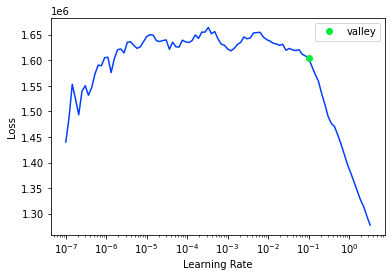

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
   actual  predicted
0 1292.00     633.02
1  975.00    1161.08
2  375.00     690.38
3  729.00     794.50
4 2034.00    1092.91
XGBoost RMSE:  813.29694


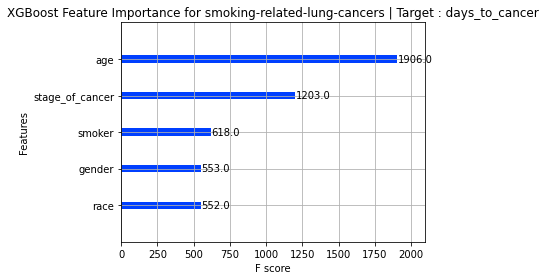

Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/pandas/core/arrays/categorical.py", line 527, in astype
    new_cats = new_cats.astype(dtype=dtype, copy=copy)
ValueError: could not convert string to float: 'Current'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/tmp/ipykernel_19/2031823437.py", line 9, in <module>
    df[df.columns[i]] = df[df.columns[i]].astype(float)
  File "/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py", line 5815, in astype
    new_data = self._mgr.astype(dtype=dtype, copy=copy, errors=errors)
  File "/opt/conda/lib/python3.7/site-packages/pandas/core/internals/managers.py", line 418, in astype
    return self.apply("astype", dtype=dtype, copy=copy, errors=errors)
  File "/opt/conda/lib/python3.7/site-packages/pandas/core/internals/managers.py", line 327, in apply
    applied = getattr(b, f)(**kwargs)
  File "/opt/conda/lib/python3.7/site-packages/pa

<Figure size 432x288 with 0 Axes>

In [24]:
df = df.copy()
target = ''
target_str = ''
#The column closest to the end isPARAM_DIR the target variable that can be represented as a float is the target variable
targets = []
#Loop through every possible target column (Continuous)
for i in range(len(df.columns)-1, 0, -1):
    try:
        df[df.columns[i]] = df[df.columns[i]].astype(float)
        target = df.columns[i]
        target_str = target.replace('/', '-')
    except:
        traceback.print_exc()
        continue
    print(f'Target Variable: {target}')
    #Will be determined by the file name


    #===================================================================================================

    #Create project config files if they don't exist.
    if not os.path.exists(param_dir):
        #create param_dir
        os.makedirs(PARAM_DIR)
    if not os.path.exists(f'{PARAM_DIR}/cats.txt'):
        #create param_dir
        with open(f'{PARAM_DIR}/cats.txt', 'w') as f:
            f.write('')
    if not os.path.exists(f'{PARAM_DIR}/conts.txt'):
        #create param_dir
        with open(f'{PARAM_DIR}/conts.txt', 'w') as f:
            f.write('')
    if not os.path.exists(f'{PARAM_DIR}/cols_to_delete.txt'):
        with open(f'{PARAM_DIR}/cols_to_delete.txt', 'w') as f:
            f.write('')

    df = df.drop_duplicates()
    if SHUFFLE_DATA:
        df = df.sample(frac=1).reset_index(drop=True)

    # workaround for fastai/pytorch bug where bool is treated as object and thus erroring out.
    for n in df:
        if pd.api.types.is_bool_dtype(df[n]):
            df[n] = df[n].astype('uint8')

    with open(f'{PARAM_DIR}/cols_to_delete.txt', 'r') as f:
        cols_to_delete = f.read().splitlines()
    for col in cols_to_delete:
        try:
            del(df[col])
        except:
            pass
    #try to fill in missing values now, otherwise FastAI will do it for us later
    try:
        df = df.fillna(0)
    except:
        pass
    #print missing values
    #print(df.isna().sum().sort_values(ascending=False))
    #shrink df as much as possible
    df = df_shrink(df)


    #print types inside of df
    #print(df.dtypes)


    #Auto detect categorical and continuous variables
    #==============================================================================
    likely_cat = {}
    for var in df.columns:
        likely_cat[var] = 1.*df[var].nunique()/df[var].count() < 0.05 #or some other threshold

    cats = [var for var in df.columns if likely_cat[var]]
    conts = [var for var in df.columns if not likely_cat[var]]

    #remove target from lists
    try:
        conts.remove(target)
        cats.remove(target)
    except:
        pass
    #Convert target to float
    df[target] = df[target].apply(pd.to_numeric, errors='coerce').dropna()

    print('CATS=====================')
    print(cats)
    print('CONTS=====================')
    print(conts)

    #Populate categorical and continuous lists
    #==============================================================================

    if VARIABLE_FILES == True:
        with open(f'{PARAM_DIR}/cats.txt', 'r') as f:
            cats = f.read().splitlines()

        with open(f'{PARAM_DIR}/conts.txt', 'r') as f:
            conts = f.read().splitlines()

    #==============================================================================

    #==============================================================================
    procs = [Categorify, FillMissing, Normalize]
    #print(df.describe().T)
    df = df[0:SAMPLE_COUNT]
    splits = RandomSplitter()(range_of(df))

    print((len(cats)) + len(conts))
    #conts = []

    #Convert cont variables to floats
    #==============================================================================

    #Convert cont variables to floats
    #==============================================================================

    for var in conts:
        try:
            df[var] = df[var].apply(pd.to_numeric, errors='coerce').dropna()
        except:
            print(f'Could not convert {var} to float.')
            pass

    #==============================================================================

    #Experimental logic to add columns one-by-one to find a breakpoint
    #==============================================================================
    if ENABLE_BREAKPOINT == True:
        temp_procs = [Categorify, FillMissing]
        print('Looping through continuous variables to find breakpoint')
        cont_list = []
        for cont in conts:
            focus_cont = cont
            cont_list.append(cont)
            #print(focus_cont)
            try:
                to = TabularPandas(df, procs=procs, cat_names=cats, cont_names=cont_list, y_names=target, y_block=RegressionBlock(), splits=splits)
                del(to)
            except:
                print('Error with ', focus_cont)
                #remove focus_cont from list
                cont_list.remove(focus_cont)
                #traceback.print_exc()
                continue
        #convert all continuous variables to floats
        for var in cont_list:
            try:
                df[var] = df[var].apply(pd.to_numeric, errors='coerce').dropna()
            except:
                print(f'Could not convert {var} to float.')
                cont_list.remove(var)
                if CONVERT_TO_CAT == True:
                    cats.append(var)
                pass
        print(f'Continuous variables that made the cut : {cont_list}')
        print(f'Categorical variables that made the cut : {cats}')
        #shrink df as much as possible
        df = df_shrink(df)
        #print(df.dtypes)

    #==============================================================================

    #Creating tabular object + quick preprocessing
    #==============================================================================
    to = None
    if REGRESSOR == True:
        try:
            to = TabularPandas(df, procs, cats, conts, target, y_block=RegressionBlock(), splits=splits)
        except:
            conts = []
            to = TabularPandas(df, procs, cats, conts, target, y_block=RegressionBlock(), splits=splits)
    else:
        try:
            to = TabularPandas(df, procs, cats, conts, target, splits=splits)
        except:
            conts = []
            to = TabularPandas(df, procs, cats, conts, target, splits=splits)

    #print(dir(to))
    #print(to.xs)
    dls = to.dataloaders()
    print(f'Tabular Object size: {len(to)}')
    try:
        dls.one_batch()
    except:
        print(f'problem with getting one batch of {PROJECT_NAME}')
    #==============================================================================

    #Extracting train and test sets from tabular object
    #==============================================================================

    X_train, y_train = to.train.xs, to.train.ys.values.ravel()
    X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()

    #Make sure target isn't in independent columns
    if target in X_train and target in X_test:
        del(X_train[target])
        del(X_test[target])
    #create dataframe from X_train and y_train
    #export tabular object to csv
    pd.DataFrame(X_train).to_csv(f'{PARAM_DIR}/X_train_{target_str}.csv', index=False)
    pd.DataFrame(X_test).to_csv(f'{PARAM_DIR}/X_test_{target_str}.csv', index=False)
    pd.DataFrame(y_train).to_csv(f'{PARAM_DIR}/y_train_{target_str}.csv', index=False)
    pd.DataFrame(y_test).to_csv(f'{PARAM_DIR}/y_test_{target_str}.csv', index=False)

    #==============================================================================

    #==============================================================================

    #Ready for model selection!

    if REGRESSOR == True:
        try:
            reg = LazyRegressor(verbose=2, ignore_warnings=False, custom_metric=None)
            models, predictions = reg.fit(X_train, X_test, y_train, y_test)
            print(f'Project: {PROJECT_NAME}')
            print(PROJECT_NAME)
            print(f'Target: {target}')
            print(target)
            target_std = y_train.std()
            print(f'Target Standard Deviation: {target_std}')
            print(models)
            models['project'] = PROJECT_NAME
            models['target'] = target
            models['target_std'] = target_std
            #rename index of 
            models.to_csv(f'{PARAM_DIR}/regression_results_{target_str}.csv', mode='a', header=True, index=True)
        except:
            print('Issue during lazypredict analysis')
    else:
        #TODO: remove this
        try:
            clf = LazyClassifier(verbose=2, ignore_warnings=False, custom_metric=None)
            models, predictions = clf.fit(X_train, X_test, y_train, y_test)
            print(f'Project: {PROJECT_NAME}')
            print(PROJECT_NAME)
            print(f'Target: {target}')
            print(target)
            print(f'Target Standard Deviation: {y_train.std()}')
            print(models)
            models.to_csv(f'{PARAM_DIR}/classification_results.csv', mode='a', header=False)
        except:
            print('Issue during lazypredict analysis')

    model_name = 'tabnet'

    # FastAI + pre-trained TabNet
    #==============================================================================
    learn = None
    i = 0
    while True:
        try:
            del learn
        except:
            pass
        try:
            learn = 0
            model = TabNetModel(get_emb_sz(to), len(to.cont_names), dls.c, n_d=64, n_a=64, n_steps=5, virtual_batch_size=256)
            # save the best model so far, determined by early stopping
            cbs = [SaveModelCallback(monitor='_rmse', comp=np.less, fname=f'{model_name}_{PROJECT_NAME}_{target_str}_best'), EarlyStoppingCallback()]
            learn = Learner(dls, model, loss_func=MSELossFlat(), metrics=rmse, cbs=cbs)
            #learn = get_learner(to)
            if(learn != 0):
                break
            if i > 50:
                break
        except:
            i += 1
            print('Error in FastAI TabNet')
            traceback.print_exc()
            continue
    try:
        #display learning rate finder results
        x = learn.lr_find()
    except:
        pass
    if AUTO_ADJUST_LEARNING_RATE == True:
        FASTAI_LEARNING_RATE = x.valley
    print(f'LEARNING RATE: {FASTAI_LEARNING_RATE}')
    try:
        if i < 50:
            learn.fit_one_cycle(20, FASTAI_LEARNING_RATE)
            plt.figure(figsize=(10, 10))
            try:
                ax = learn.show_results()
                plt.show(block=True)
            except:
                print('Could not show results')
                pass
    except:
        print('Could not fit model')
        traceback.print_exc()
        pass

    #==============================================================================

    #fit an xgboost model
    #==============================================================================
    if REGRESSOR == True:
        xgb = XGBRegressor()
    else:
        xgb = XGBClassifier()
    try:
        xgb = XGBRegressor()
        xgb.fit(X_train, y_train)
        y_pred = xgb.predict(X_test)
        print('XGBoost Predictions vs Actual==========')
        print(pd.DataFrame({'actual': y_test, 'predicted': y_pred}).head())
        print('XGBoost RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred)))
        #save feature importance plot to file
        plot_importance(xgb)
        plt.title(f'XGBoost Feature Importance for {PROJECT_NAME} | Target : {target}', wrap=True)
        plt.tight_layout()
        plt.show()
        plt.savefig(f'{PARAM_DIR}/xgb_feature_importance_{target_str}.png')
        fi_df = pd.DataFrame([xgb.get_booster().get_score()]).T
        fi_df.columns = ['importance']
        #create a column based off the index called feature
        fi_df['feature'] = fi_df.index
        #create a dataframe of feature importance
        fi_df = fi_df[['feature', 'importance']]
        fi_df.to_csv(f'{PARAM_DIR}/xgb_feature_importance_{target_str}.csv', index=False)
        #xgb_fi = pd.DataFrame(xgb.feature_importances_, index=X_train.columns, columns=['importance'])
        #xgb_fi.to_csv(f'{PARAM_DIR}/xgb_feature_importance_{target_str}.csv')
        #print('XGBoost AUC: ', roc_auc_score(y_test, y_pred))
    except:
        traceback.print_exc()
        print('XGBoost failed')

# <div style="text-align: center; background-color: blue; color: white; padding: 14px; line-height: 1;border-radius:20px">**Overall Feature Importance**</div>

           feature  importance
0              age     1906.00
1           gender      553.00
2             race      552.00
3           smoker      618.00
4  stage_of_cancer     1203.00


<AxesSubplot:title={'center':'XGBoost Overall Feature Importance'}, xlabel='feature'>

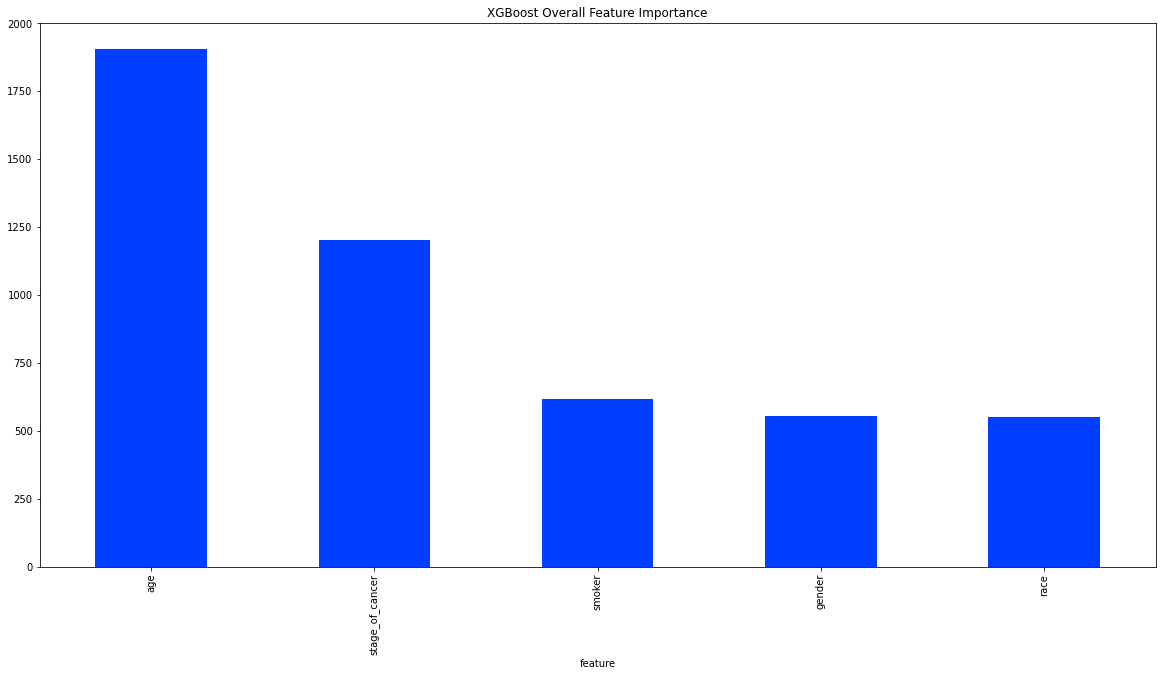

In [25]:
out_dir = f'./{PROJECT_NAME}'
xgb_feature_importance_csvs = []

for file in os.listdir(out_dir):
    if 'xgb_feature_importance' in file and '.csv' in file:
        xgb_feature_importance_csvs.append(pd.read_csv(os.path.join(out_dir, file)))

xgb_feature_importance = pd.concat(xgb_feature_importance_csvs,axis=0)
xgb_feature_importance.rename(columns={'Unnamed: 0': 'feature'}, inplace=True)
print(xgb_feature_importance.head())
xgb_feature_importance.groupby('feature')['importance'].mean().sort_values(ascending=False).plot(kind='bar', title='XGBoost Overall Feature Importance', figsize=(20, 10))

In [26]:
df.isna().sum()

age                0
gender             0
race               0
smoker             0
days_to_cancer     0
stage_of_cancer    0
dtype: int64

# **To Be Continued...**